# PyTorch Vanilla GAN

In this notebook I will implement a basic GAN achitecture for generative MNIST handwritten digits.

In [78]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [79]:
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'cpu' 
)
device

device(type='cuda')

In [80]:
class MNISTGenerator(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.generator_model = nn.Sequential(
            nn.Linear(in_features=20, out_features=100),
            nn.LeakyReLU(),
            nn.Linear(in_features=100, out_features=784),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        return self.generator_model(x)

In [81]:
MNISTGenerator('cpu')

MNISTGenerator(
  (generator_model): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): Tanh()
  )
)

In [82]:
class MNISTDiscriminator(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.discriminator_model = nn.Sequential(
            nn.Linear(in_features=784, out_features=100, bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=100, out_features=1, bias=True),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        return self.discriminator_model(x)

In [83]:
image_path = './'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

mnist_dataset = torchvision.datasets.MNIST(
    image_path, train=True,
    transform=transform, download=True
)

In [84]:
def make_some_noise(batch_size, z_size=20, mode='uniform'):
    if mode == 'uniform':
        input_z = torch.rand(batch_size, z_size) * 2 - 1
    elif mode == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [85]:
batch_size = 64
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True)

gen_model = MNISTGenerator(device)
disc_model = MNISTDiscriminator(device)

loss = nn.BCELoss()
gen_optimizer = torch.optim.Adam(gen_model.parameters())
disc_optimizer = torch.optim.Adam(disc_model.parameters())

In [86]:
def discriminator_train(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    disc_labels_real = torch.ones(batch_size, 1, device=device)
    disc_proba_real = disc_model(x)
    disc_loss_real = loss(disc_proba_real, disc_labels_real)

    input_z = make_some_noise(
        batch_size, z_size=20, mode='uniform'
    ).to(device)
    gen_output = gen_model(input_z)
    disc_proba_fake = disc_model(gen_output)
    disc_labels_fake = torch.zeros(batch_size, 1, device=device)
    disc_loss_fake = loss(disc_proba_fake, disc_labels_fake)

    disc_loss = disc_loss_real + disc_loss_fake
    disc_loss.backward()
    disc_optimizer.step()

    return disc_loss.data.item(), disc_proba_real.detach(),\
           disc_proba_fake.detach()

In [87]:
def generator_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)

    input_z = make_some_noise(batch_size).to(device)
    gen_labels_real = torch.ones(batch_size, 1, device=device)

    gen_output = gen_model(input_z)
    disc_proba_fake = disc_model(gen_output)
    gen_loss = loss(disc_proba_fake, gen_labels_real)

    gen_loss.backward()
    gen_optimizer.step()

    return gen_loss.data.item()

In [88]:
fixed_z = make_some_noise(
    batch_size, z_size=20, mode='uniform'
).to(device)

def create_samples(gen_model, input_z):
    gen_output = gen_model(input_z)
    images = torch.reshape(gen_output, (batch_size, 28, 28))
    return (images+1)/2.0

In [89]:
epoch_samples = []
disc_loss_history = []
gen_loss_history = []
disc_real_history = []
disc_fake_history = []

n_epochs = 100

for epoch in range(1, n_epochs + 1):
    disc_losses, gen_losses = [], []
    disc_real_vals, disc_fake_vals = [], []

    for i, (x, _) in enumerate(mnist_loader):
        disc_loss, disc_proba_real, disc_proba_fake = discriminator_train(x)
        disc_losses.append(disc_loss)
        gen_losses.append(generator_train(x))
        disc_real_vals.append(disc_proba_real.mean().cpu())
        disc_fake_vals.append(disc_proba_fake.mean().cpu())

    disc_loss_history.append(torch.tensor(disc_losses).mean())
    gen_loss_history.append(torch.tensor(gen_losses).mean())
    disc_real_history.append(torch.tensor(disc_real_vals).mean())
    disc_fake_history.append(torch.tensor(disc_fake_vals).mean())

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {gen_loss_history[-1]:.4f}/{disc_loss_history[-1]:.4f}'
          f' [D-Real: {disc_real_history[-1]:.4f}'
          f' D-Fake: {disc_fake_history[-1]:.4f}]')
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy()
    )

Epoch 001 | Avg Losses >> G/D 0.8507/0.9372 [D-Real: 0.7981 D-Fake: 0.4851]
Epoch 002 | Avg Losses >> G/D 0.8972/1.2086 [D-Real: 0.5853 D-Fake: 0.4557]
Epoch 003 | Avg Losses >> G/D 0.9206/1.2075 [D-Real: 0.5755 D-Fake: 0.4339]
Epoch 004 | Avg Losses >> G/D 0.8260/1.2766 [D-Real: 0.5516 D-Fake: 0.4588]
Epoch 005 | Avg Losses >> G/D 0.9408/1.2274 [D-Real: 0.5677 D-Fake: 0.4258]
Epoch 006 | Avg Losses >> G/D 0.9911/1.1868 [D-Real: 0.5867 D-Fake: 0.4158]
Epoch 007 | Avg Losses >> G/D 1.0713/1.1444 [D-Real: 0.6031 D-Fake: 0.3923]
Epoch 008 | Avg Losses >> G/D 0.9433/1.2109 [D-Real: 0.5792 D-Fake: 0.4240]
Epoch 009 | Avg Losses >> G/D 0.9861/1.1847 [D-Real: 0.5874 D-Fake: 0.4100]
Epoch 010 | Avg Losses >> G/D 0.9504/1.2087 [D-Real: 0.5814 D-Fake: 0.4216]
Epoch 011 | Avg Losses >> G/D 1.0033/1.1840 [D-Real: 0.5914 D-Fake: 0.4099]
Epoch 012 | Avg Losses >> G/D 1.0554/1.1650 [D-Real: 0.5974 D-Fake: 0.3994]
Epoch 013 | Avg Losses >> G/D 0.9112/1.2313 [D-Real: 0.5727 D-Fake: 0.4315]
Epoch 014 | 

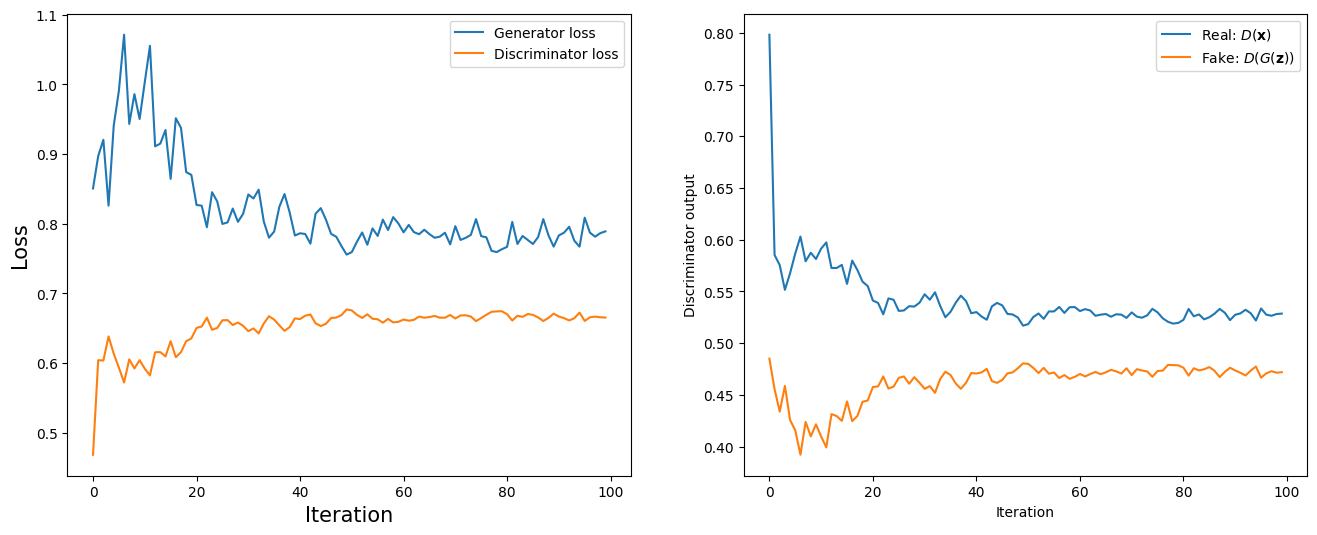

In [90]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(gen_loss_history, label='Generator loss')
disc_halved_losses = [disc_loss/2 for disc_loss in disc_loss_history]
plt.plot(disc_halved_losses, label='Discriminator loss')
plt.legend()
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(disc_real_history, label=r'Real: $D(\mathbf{x})$')
plt.plot(disc_fake_history, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Discriminator output')
plt.show()

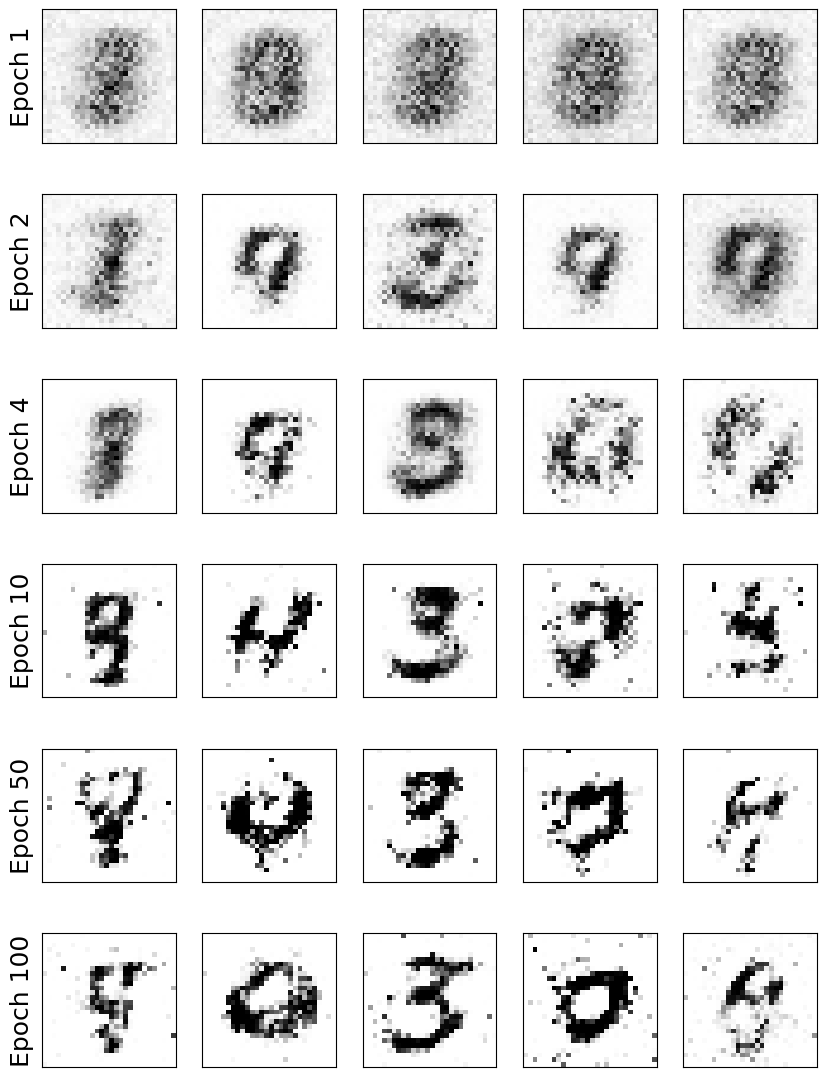

In [93]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18,
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes
            )
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()